In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from scipy.optimize import curve_fit
from scipy.integrate import simps
from scipy.optimize import curve_fit

## Define Functions

In [2]:
## calculate cost of perturbation due to carbon
## input: temperature profile, perturbed temperature profile, total consumption, and discount function

def cost_of_perturbation(W, W_prime, discount_function, gamma=2, D0=0.00267):
    absolute_consumption_loss = W-W_prime
    discounted_consumption_loss = absolute_consumption_loss*discount_function
#     area = simps(discounted_consumption_loss, dx=1)
    area = sum(discounted_consumption_loss)
    cost = area*10**12  # convert to dollar amount
    
    return cost

In [3]:
## calculate abatement given a carbon price

## default settings
P_50 = 120  # 187.5 * 0.7625000000000001
P_100 = 300  # 187.5
g_2019 = 0.02
g_grad = 0.001  # 0.00034
W_2019 = 80
growth_adjustment = 0.015
consumption_discount = g_2019 + 0.015
s = 0.05
r = 0.03
# r = consumption_discount
# s = 3 * r
P0_prime = 20.578247449781294

## test
# consumption_discount=0.025
# g_2019=0.01
# P_50=385.4296875
# s=0.1712667164711362
# r=0.025
# P_100=487.5
# growth_adjustment = 0.015
# W_2019 = 80
# P0_prime = 30
# g_grad = 0.0026

## test 
# P_100 = 287.5
# P_50 = P_100 * 0.528125
# g_2019 = 0.01
# g_grad = 0.0013  # g_grad = 0.0004
# W_2019 = 80
# growth_adjustment = 0.015
# consumption_discount = g_2019 + growth_adjustment
# constraint = 5  # param_values_2[i][1]
# r = consumption_discount
# s = r * np.log(constraint)/np.log((P_100)/(P_50))
# P0_prime = 31.33586359531034

    
# P_50 = 300  # 187.5 * 0.7625000000000001
# P_100 = 500  # 187.5
# g_2019 = 0.02
# g_grad = 0.0013 # 0.00034
# W_2019 = 80
# consumption_discount = g_2019 + 0.015
# s = 0.05
# r = 0.03
# P0_prime = 20
# # s = 0.1


def abatement(P, P0, P_50=P_50, r=r, s=s, P_100=P_100):  # 0.05
    if P0 >= P_50:
        print("P0 is greater than P_50")
    elif ((P_100-P0)/(P_50-P0))**(s/r) <= 2:
        print("MAC curve condition not satisfied")
    
    P_h = P0 + ((P_50 - P0) ** (-s / r) - 2 * (P_100 - P0) ** (-s / r)) ** (-r / s)
    Am = 1 + ((P_100 - P0) / (P_h - P0)) ** (-s / r)
    
    A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))
    
    return A

In [4]:
## calculate emissions from forecasted abatement and CO2 baseline

def abatement_to_emissions(forecasted_abatement, CO2_baseline):
    CO2_emissions = CO2_baseline*(1-forecasted_abatement)
    
    return CO2_emissions

In [5]:
def create_W(W_2019, last_historical_year, start_year, T_forecast_years, g):
    W = []
    W_historical = [W_2019] * (last_historical_year - start_year + 1)
    W_forecast = []
    W_previous_year = W_historical[-1]

    for i in range(len(T_forecast_years) - 1):
        W_this_year = W_previous_year*np.exp(g[i])
        W_forecast.append(W_this_year)
        W_previous_year = W_this_year

    W = W_historical + W_forecast

    W = np.asarray(W)
    return W

# Steps outlined in Email

## 1. Create Unperturbed Temperature Profile

In [6]:
# get historical data (taken from chrisroadmap)

T_gas_df = pd.read_csv("T_gas.csv", index_col=0)

# T_2019 = T_gas_df['CO2_best'][2019]
T_2019 = 1.2

In [7]:
start_year = 1750
last_historical_year = 2019
end_year = 3000

years = np.arange(start_year, end_year+1)
T_forecast_years = np.arange(last_historical_year, end_year+1)
T_forecast_length = end_year - last_historical_year + 1

In [8]:
delta_T = 3
alpha = 0.02
T_forecast = T_2019 + (delta_T - T_2019) * (1 - np.exp(-alpha*np.arange(T_forecast_length)))

In [9]:
T = np.concatenate([T_gas_df['CO2_best'].loc[:2018],T_forecast])

In [10]:
T

array([0.00000000e+00, 7.83130520e-05, 2.88090765e-04, ...,
       2.99999999e+00, 2.99999999e+00, 2.99999999e+00])

In [11]:
T[2019-start_year:]

array([1.2       , 1.23564239, 1.27057901, 1.30482384, 1.33839058,
       1.37129265, 1.40354321, 1.43515518, 1.46614118, 1.49651362,
       1.52628464, 1.55546616, 1.58406985, 1.61210715, 1.63958927,
       1.6665272 , 1.69293173, 1.71881342, 1.74418261, 1.76904946,
       1.79342392, 1.81731572, 1.84073444, 1.86368944, 1.88618989,
       1.90824481, 1.92986301, 1.95105315, 1.97182369, 1.99218294,
       2.01213906, 2.03170001, 2.05087364, 2.0696676 , 2.08808941,
       2.10614645, 2.12384594, 2.14119495, 2.15820043, 2.17486918,
       2.19120786, 2.20722302, 2.22292106, 2.23830825, 2.25339076,
       2.26817461, 2.28266573, 2.2968699 , 2.31079281, 2.32444002,
       2.33781701, 2.35092911, 2.36378157, 2.37637954, 2.38872805,
       2.40083205, 2.41269637, 2.42432576, 2.43572487, 2.44689827,
       2.45785042, 2.4685857 , 2.47910841, 2.48942275, 2.49953286,
       2.50944277, 2.51915646, 2.5286778 , 2.5380106 , 2.5471586 ,
       2.55612546, 2.56491477, 2.57353003, 2.58197471, 2.59025

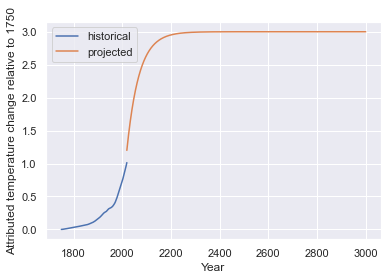

In [12]:
plt.plot(T_gas_df['CO2_best'], label="historical")
plt.plot(T_forecast_years, T_forecast, label="projected")
plt.xlabel("Year")
plt.ylabel("Attributed temperature change relative to 1750")
plt.legend()

## 2. Calculate SCC as a function of time for a range of years

In [13]:
## years to calculate SCC
first_perturbed_year = last_historical_year
last_perturbed_year = 2500
year_of_perturbation = np.arange(first_perturbed_year, last_perturbed_year+1)


SCC_list = []
SCC_list_actual = []

for j in range(len(year_of_perturbation)):
    ## define perturbed temperature profile for a given year
    T_TCRE = 0.00045  # need to check this for FAIR!
    k_s = 0.12

    T_p = np.zeros(T_forecast_length)
    for i in range(len(T_forecast_years)):
        if year_of_perturbation[j] <= T_forecast_years[i]:
            T_p[i] = T_TCRE*(1-np.exp(-k_s*(T_forecast_years[i]-year_of_perturbation[j])))
    T_forecast_perturbed = T_forecast+T_p
    T_perturbed = np.concatenate([T_gas_df['CO2_best'].loc[:2018],T_forecast_perturbed])
    

    g = g_2019 - g_grad*(T[:-1]**2-T_2019**2)
    g_prime = g_2019 - g_grad*(T_perturbed[:-1]**2-T_2019**2)
    
    growth_adjusted_consumption_discount = g[last_historical_year-start_year+j] + growth_adjustment
    
    g = g[last_historical_year-start_year:]
    g_prime = g_prime[last_historical_year-start_year:]

    W = create_W(W_2019, last_historical_year, start_year, T_forecast_years, g)
    W_prime = create_W(W_2019, last_historical_year, start_year, T_forecast_years, g_prime)
    
#     if j == 0:
#         print(W[2019-start_year:])
#         print(W_prime[2019-start_year:])
#         print(g[2019-start_year:])
#         print(T_perturbed[2019-start_year:])
#         print(T[:-1])
#         plt.yscale("log")

    ## define discount function
    num_of_years = len(years)
    discount_function = np.zeros(num_of_years)


    for i in range(num_of_years):
        if years[i] >= year_of_perturbation[j]:
            discount_function[i] = np.exp(-growth_adjusted_consumption_discount*(years[i]-year_of_perturbation[j]))
    
    cost = cost_of_perturbation(W, W_prime, discount_function, gamma=2, D0=0.00267)
    SCC = cost/(10**9)
    SCC_list_actual.append(SCC)
    
    if j == 0 and P0_prime > P_100:
        print("P_100 achieved in first year")
    elif j == 0:  #  and SCC > P_100
        P0 = SCC
        SCC_adjusted = SCC - (P0-P0_prime)
        SCC_list.append(P0_prime)
        W_first = W
        W_first_perturbed = W_prime
        g_first = g
        print(SCC)
    else:
        SCC_adjusted = SCC - (P0-P0_prime)
        if SCC_adjusted < P_100:
            SCC_list.append(SCC_adjusted)
        else:
            SCC_list.append(P_100)
            break

363.64749961551473


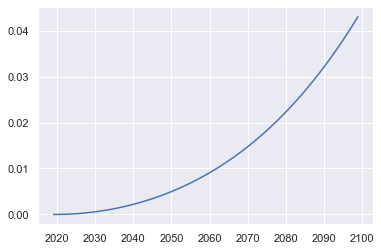

In [14]:
plt.plot(years[2019-start_year:2100-start_year], (W_first-W_first_perturbed)[2019-start_year:2100-start_year])

In [15]:
SCC_list_actual

[363.64749961551473,
 375.1401869149662,
 386.937767111432,
 399.0447265741423,
 411.46554560274984,
 424.2046959449319,
 437.2666385149673,
 450.655821265189,
 464.3766771897414,
 478.4336224754798,
 492.83105483741286,
 507.5733519327275,
 522.6648699928255,
 538.1099424933193,
 553.9128790710362,
 570.0779645048955,
 586.6094578211839,
 603.5115916118085,
 620.788571384084,
 638.4445751406047,
 656.483752942674]

In [16]:
SCC_array = np.asarray(SCC_list)  # convert to numpy array

In [17]:
SCC_array

array([ 20.57824745,  32.07093475,  43.86851495,  55.97547441,
        68.39629344,  81.13544378,  94.19738635, 107.5865691 ,
       121.30742502, 135.36437031, 149.76180267, 164.50409977,
       179.59561783, 195.04069033, 210.84362691, 227.00871234,
       243.54020566, 260.44233945, 277.71931922, 295.37532297,
       300.        ])

Text(0, 0.5, 'SCC ($)')

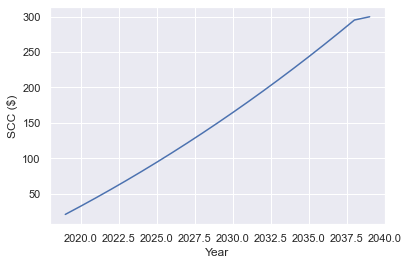

In [18]:
plt.plot(year_of_perturbation[:len(SCC_array)], SCC_array)
plt.xlabel("Year")
plt.ylabel("SCC ($)")

### Check 100% abatement has been achieved!

In [19]:
if SCC_array[-1] < P_100:
    print("P_100 not achieved by achieved by final perturbed year")

In [20]:
SCC_forecasted = []

for i in range(T_forecast_length):
    if i < len(SCC_array):
        SCC_forecasted.append(SCC_array[i])
    else:
#         SCC_forecasted.append(SCC_array[-1])
        SCC_forecasted.append(P_100)

SCC_forecasted = np.array(SCC_forecasted)

In [21]:
# SCC_forecasted

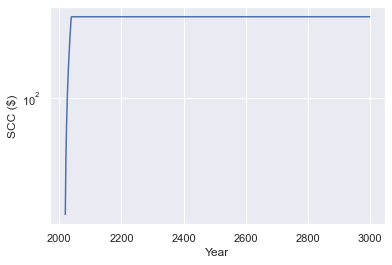

In [22]:
plt.plot(T_forecast_years, SCC_forecasted)
plt.xlabel("Year")
plt.ylabel("SCC ($)")
plt.yscale("log")

## 3. Abatement as a function of time

In [23]:
P0 = SCC_forecasted[0]

In [24]:
# P0

In [25]:
forecasted_abatement = abatement(P=SCC_forecasted, P0=P0_prime)  # , r=consumption_discount

/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_14985/1682660097.py:64: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))


In [26]:
forecasted_abatement

array([0.        , 0.02213938, 0.06915889, 0.13174968, 0.20382184,
       0.28055596, 0.35824378, 0.43420378, 0.50664317, 0.57448381,
       0.63718543, 0.69458861, 0.7467877 , 0.7940343 , 0.83666799,
       0.87506867, 0.90962531, 0.94071643, 0.96869885, 0.99390181,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.     

problems with certain values due to constraints of the model

In [27]:
((P_100-P0)/(P_50-P0))**(s/r)

5.5971205802964565

Text(0, 0.5, 'Abatement')

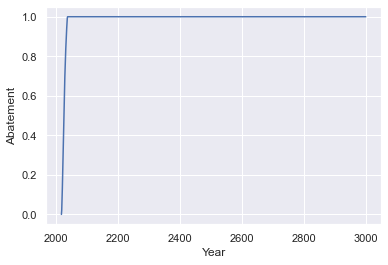

In [28]:
plt.plot(T_forecast_years, forecasted_abatement)
plt.xlabel("Year")
plt.ylabel("Abatement")

## 4. Abatement to emissions

In [29]:
ssp_df = pd.read_csv("ssp245.csv", index_col=0)

In [30]:
ssp245_CO2_past = ssp_df["carbon_dioxide"]*(44/12)  

In [31]:
# CO2_baseline = ssp245_CO2_past[2019] # set baseline to current emissions

In [32]:
CO2_baseline = 40

In [33]:
forecasted_emissions = abatement_to_emissions(forecasted_abatement, CO2_baseline)

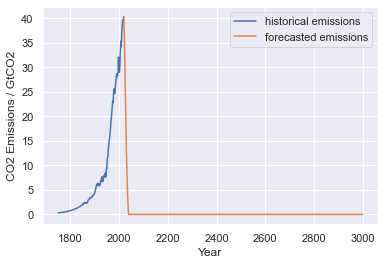

In [34]:
plt.plot(ssp245_CO2_past, label="historical emissions")
plt.plot(T_forecast_years, forecasted_emissions, label="forecasted emissions")
plt.xlabel("Year")
plt.ylabel("CO2 Emissions / GtCO2")
plt.legend()

## 5. Cumulative Emissions to Temperature Change

In [35]:
cumulative_emissions_array = np.append(np.zeros(1), np.cumsum(forecasted_emissions)[:-1])

In [36]:
temperature_change = T_TCRE*cumulative_emissions_array

In [37]:
T_forecast_iteration0 = T_2019 + temperature_change
# T_forecast_iteration0_plateau = T_2019 + temperature_change_plateau

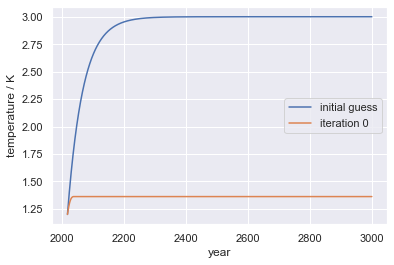

In [38]:
plt.plot(T_forecast_years, T_forecast, label="initial guess")
plt.plot(T_forecast_years, T_forecast_iteration0, label="iteration 0")
# plt.plot(T_forecast_years, T_forecast_iteration0_plateau, label="iteration 0 plateau")
plt.xlabel("year")
plt.ylabel("temperature / K")
plt.legend()

# Iterating Further

In [39]:
# T_forecast_first_loop = T_forecast_iteration0_plateau
# T_forecast_iteration = T_forecast_iteration0_plateau

In [40]:
T_forecast_first_loop = T_forecast_iteration0
T_forecast_iteration = T_forecast_iteration0

362.4454499984352
[8.00000000e+01 8.16161072e+01 8.32612380e+01 8.49358614e+01
 8.66405545e+01 8.83759803e+01 9.01428722e+01 9.19420205e+01
 9.37742589e+01 9.56404548e+01 9.75415004e+01 9.94783068e+01
 1.01451800e+02 1.03462916e+02 1.05512602e+02 1.07601817e+02
 1.09731524e+02 1.11902700e+02 1.14116331e+02 1.16373413e+02
 1.18674955e+02 1.21021980e+02 1.23415421e+02 1.25856197e+02
 1.28345244e+02 1.30883517e+02 1.33471989e+02 1.36111652e+02
 1.38803521e+02 1.41548626e+02 1.44348021e+02 1.47202779e+02
 1.50113996e+02 1.53082787e+02 1.56110292e+02 1.59197672e+02
 1.62346110e+02 1.65556815e+02 1.68831018e+02 1.72169974e+02
 1.75574965e+02 1.79047296e+02 1.82588298e+02 1.86199331e+02
 1.89881779e+02 1.93637055e+02 1.97466598e+02 2.01371878e+02
 2.05354392e+02 2.09415668e+02 2.13557263e+02 2.17780766e+02
 2.22087798e+02 2.26480009e+02 2.30959084e+02 2.35526742e+02
 2.40184734e+02 2.44934846e+02 2.49778902e+02 2.54718757e+02
 2.59756308e+02 2.64893486e+02 2.70132261e+02 2.75474644e+02
 2.809

/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_14985/1682660097.py:64: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))


1.4051714450864168
367.16823728081323
[8.00000000e+01 8.16161072e+01 8.32612380e+01 8.49358408e+01
 8.66404466e+01 8.83756537e+01 9.01421172e+01 9.19405395e+01
 9.37716623e+01 9.56362589e+01 9.75351287e+01 9.94690932e+01
 1.01438992e+02 1.03445683e+02 1.05490037e+02 1.07572941e+02
 1.09695296e+02 1.11858017e+02 1.14062034e+02 1.16308291e+02
 1.18597746e+02 1.20931376e+02 1.23310170e+02 1.25735138e+02
 1.28207307e+02 1.30727722e+02 1.33297447e+02 1.35917568e+02
 1.38589189e+02 1.41313323e+02 1.44091003e+02 1.46923282e+02
 1.49811232e+02 1.52755949e+02 1.55758548e+02 1.58820166e+02
 1.61941964e+02 1.65125125e+02 1.68370854e+02 1.71680382e+02
 1.75054963e+02 1.78495875e+02 1.82004422e+02 1.85581934e+02
 1.89229766e+02 1.92949301e+02 1.96741947e+02 2.00609142e+02
 2.04552352e+02 2.08573070e+02 2.12672820e+02 2.16853156e+02
 2.21115661e+02 2.25461950e+02 2.29893671e+02 2.34412503e+02
 2.39020157e+02 2.43718381e+02 2.48508953e+02 2.53393690e+02
 2.58374443e+02 2.63453098e+02 2.68631579e+02 2

/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_14985/1682660097.py:64: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))


1.3976096102534405
366.3864856464507
[8.00000000e+01 8.16161072e+01 8.32612380e+01 8.49358428e+01
 8.66404573e+01 8.83756867e+01 9.01421950e+01 9.19406960e+01
 9.37719437e+01 9.56367254e+01 9.75358551e+01 9.94701694e+01
 1.01440523e+02 1.03447788e+02 1.05492851e+02 1.07576611e+02
 1.09699983e+02 1.11863893e+02 1.14069283e+02 1.16317108e+02
 1.18608335e+02 1.20943950e+02 1.23324953e+02 1.25752358e+02
 1.28227199e+02 1.30750526e+02 1.33323408e+02 1.35946918e+02
 1.38622053e+02 1.41349829e+02 1.44131282e+02 1.46967467e+02
 1.49859462e+02 1.52808366e+02 1.55815297e+02 1.58881398e+02
 1.62007833e+02 1.65195790e+02 1.68446478e+02 1.71761133e+02
 1.75141013e+02 1.78587401e+02 1.82101607e+02 1.85684964e+02
 1.89338835e+02 1.93064605e+02 1.96863690e+02 2.00737533e+02
 2.04687604e+02 2.08715404e+02 2.12822463e+02 2.17010339e+02
 2.21280623e+02 2.25634937e+02 2.30074935e+02 2.34602302e+02
 2.39218757e+02 2.43926054e+02 2.48725980e+02 2.53620358e+02
 2.58611047e+02 2.63699941e+02 2.68888974e+02 2.

1.398751357996013
2


/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_14985/1682660097.py:64: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))


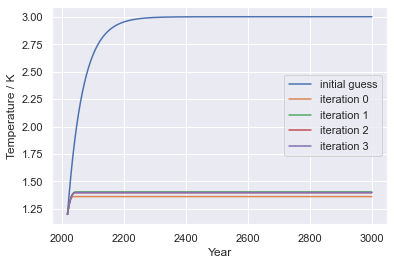

In [41]:
num_of_iterations = 99

first_perturbed_year = last_historical_year

year_of_perturbation = np.arange(first_perturbed_year, last_perturbed_year+1)

plt.plot(T_forecast_years, T_forecast, label="initial guess")
plt.plot(T_forecast_years, T_forecast_first_loop, label="iteration 0")

for k in range(num_of_iterations):
    T_iteration = np.concatenate([T_gas_df['CO2_best'].loc[:2018],T_forecast_iteration])

    SCC_list = []
    SCC_list_actual = []

    for j in range(len(year_of_perturbation)):
        ## define perturbation
        T_TCRE = 0.00045  # need to check this! *100 for 100GtCO2 added
        k_s = 0.12

        T_p = np.zeros(T_forecast_length)

        for i in range(len(T_forecast_years)):
            if year_of_perturbation[j] <= T_forecast_years[i]:
                T_p[i] = T_TCRE*(1-np.exp(-k_s*(T_forecast_years[i]-year_of_perturbation[j])))

        T_forecast_perturbed = T_forecast_iteration+T_p

#         T_perturbed = np.concatenate([T_gas_df['CO2_best'],T_forecast_perturbed[1:]])
        T_perturbed = np.concatenate([T_gas_df['CO2_best'].loc[:2018],T_forecast_perturbed])
        g = g_2019 - g_grad*(T_iteration[:-1]**2-T_2019**2)
        g_prime = g_2019 - g_grad*(T_perturbed[:-1]**2-T_2019**2)
        
        growth_adjusted_consumption_discount = g[last_historical_year-start_year+j] + growth_adjustment

        g = g[last_historical_year-start_year:]
        g_prime = g_prime[last_historical_year-start_year:]
    
        W = create_W(W_2019, last_historical_year, start_year, T_forecast_years, g)
        W_prime = create_W(W_2019, last_historical_year, start_year, T_forecast_years, g_prime)

        ## define discount function
        num_of_years = len(years)

        discount_function = np.zeros(num_of_years)

        for i in range(num_of_years):
            if years[i] >= year_of_perturbation[j]:
                discount_function[i] = np.exp(-growth_adjusted_consumption_discount*(years[i]-year_of_perturbation[j]))

        absolute_consumption_loss = W-W_prime
        discounted_consumption_loss = absolute_consumption_loss*discount_function
        area = simps(discounted_consumption_loss, dx=1)
        cost = area*10**12  # convert to dollar amount
        
        SCC = cost/(10**9)
        SCC_list_actual.append(SCC)
        
#         if SCC < P_100:
#             SCC_list.append(SCC)
#         else:
#             SCC_list.append(P_100)
#             break
        if j == 0 and P0_prime > P_100:
            print("P_100 achieved in first year")
            print(SCC)
        elif j == 0:  #  and SCC > P_100
            P0 = SCC
            print(SCC)
            SCC_list.append(P0_prime)
            print(W[2019-start_year:])            
        else:
            SCC_adjusted = SCC - (P0-P0_prime)
            if SCC_adjusted < P_100:
                SCC_list.append(SCC_adjusted)
        #         print(SCC)
            else:
                SCC_list.append(P_100)
                break

    SCC_array = np.asarray(SCC_list)
    if SCC_array[-1] < P_100:
        print("P_100 not achieved by achieved by final perturbed year")
    SCC_forecasted = []

    for i in range(T_forecast_length):
        if i < len(SCC_array):
            SCC_forecasted.append(SCC_array[i])
        else:
            SCC_forecasted.append(P_100)

    SCC_forecasted = np.array(SCC_forecasted)

    P0 = SCC_forecasted[0]

    forecasted_abatement = abatement(P=SCC_forecasted, P0=P0_prime)  # , r=consumption_discount
    forecasted_emissions = abatement_to_emissions(forecasted_abatement, CO2_baseline)

    cumulative_emissions_array = np.append(np.zeros(1), np.cumsum(forecasted_emissions)[:-1])

    temperature_change = T_TCRE*cumulative_emissions_array
    
    T_forecast_iteration = T_2019 + temperature_change
    
    plt.plot(T_forecast_years, T_forecast_iteration, label="iteration "+str(k+1))
    
    if k == 0:
        peak_T = max(T_forecast_iteration)
        print(peak_T)
    else:
        previous_peak_T = peak_T
        peak_T = max(T_forecast_iteration)
        print(peak_T)
        if abs(peak_T - previous_peak_T) < 0.005:
            print(k)
            break
    
    if k == num_of_iterations - 1:
        print("convergence condition not achieved")
        print(f"{consumption_discount=}")
        print(f"{g_2019=}")
        print(f"{P_50=}")
        print(f"{s=}")
        print(f"{r=}")
        print(f"{P_100=}")

plt.xlabel("Year")
plt.ylabel("Temperature / K")
plt.legend()

In [42]:
P0

20.578247449781294

In [43]:
## peak Temperature
max(T_forecast_iteration)

1.398751357996013

In [44]:
SCC_forecasted

array([ 20.57824745,  30.40682451,  40.45361278,  50.67162852,
        61.03125371,  71.50191543,  82.06731917,  92.70898316,
       103.42213962, 114.19779235, 125.03943783, 135.94415335,
       146.92049163, 157.9688261 , 169.10047165, 180.31728538,
       191.63194469, 203.04673782, 214.5749229 , 226.218646  ,
       237.99132919, 249.89466966, 261.94202912, 274.13448429,
       286.48520631, 298.99452465, 300.        , 300.        ,
       300.        , 300.        , 300.        , 300.        ,
       300.        , 300.        , 300.        , 300.        ,
       300.        , 300.        , 300.        , 300.        ,
       300.        , 300.        , 300.        , 300.        ,
       300.        , 300.        , 300.        , 300.        ,
       300.        , 300.        , 300.        , 300.        ,
       300.        , 300.        , 300.        , 300.        ,
       300.        , 300.        , 300.        , 300.        ,
       300.        , 300.        , 300.        , 300.  

In [45]:
SCC_list_actual

[366.3864856464507,
 376.215062701862,
 386.26185097812083,
 396.4798667148852,
 406.8394919044187,
 417.31015362571856,
 427.8755573625931,
 438.5172213572499,
 449.2303778151617,
 460.00603055093075,
 470.8476760312186,
 481.7523915443125,
 492.7287298218917,
 503.7770642948276,
 514.9087098505098,
 526.1255235815365,
 537.4401828914474,
 548.8549760128744,
 560.3831610934399,
 572.0268841948772,
 583.7995673840106,
 595.7029078611283,
 607.7502673130781,
 619.942722484071,
 632.2934445046451,
 644.8027628503626,
 657.4926245867318]

hard constraint on absolute reduction that can be achieved in one year

2.013549671765545

- max ~2GtCO2 in year (look in IAMs)
- directions MACC non...
- comment on efficiency
- equation on flowchart
- balance between forcing log and errors
- gradient MACC
- table for Sobol
- peak warming and year of peak warming; scatter with growth rate